# Metabolism at a glance - Exercises

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import numpy

Hint: Use page 76 and forward in Villadsen et al
An average biomass elemental composition of CH1.8O0.5N0.2 may be used

## Batch data analysis

A yeast strain was cultivated in batch culture under anaerobic conditions and samples were analyzed for the dry weight, glucose, ethanol and glycerol concentrations.

Let's read the file using pandas (we're going to ignore the comment lines in the beginning).

In [34]:
batch_data = pd.read_csv("data/batch-data-analysis-data.csv")
batch_data

,time [h],biomass [DW g/l],glucose [g/l],ethanol [g/l],glycerol [g/l]
0,0.00,0.0068,NaN,NaN,NaN
1,0.50,0.0100,20.02,0.00,0.01
2,2.42,0.0150,20.09,0.02,0.02
3,4.50,0.0190,20.00,0.03,0.02
4,6.34,0.0286,19.68,0.04,0.05
5,9.25,0.0608,19.47,0.17,0.15
6,11.34,0.1100,19.21,0.31,0.32
7,14.17,0.2300,18.12,0.68,0.36
8,17.17,0.4920,15.47,1.55,0.73
9,17.84,0.5560,14.34,1.96,0.82


### a)

Plot the data, find the region with the exponential growth and find $μ_{max}$

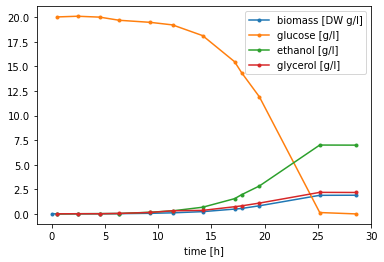

In [35]:
batch_data.plot(x='time [h]', style='.-');

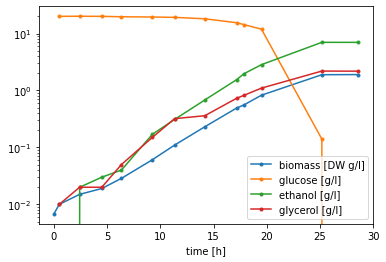

In [36]:
batch_data.plot(x='time [h]', logy=True, style='.-');

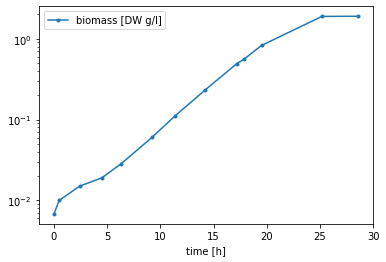

In [37]:
fig = batch_data.plot(x='time [h]', y='biomass [DW g/l]', logy=True, style='.-');

Let's use scipy to fit an expontial function to the data $f = a e^{\mu_{max} t}$. https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

In [38]:
from scipy.optimize import curve_fit

In [39]:
func = lambda t, a, mu_max: a*numpy.exp(mu_max*t)

Through visual inspection, rows 5-11 (4-10 using Python indexing) should provide a suitable range for curve fitting.

In [40]:
exp_time_points = batch_data.loc[4:10, 'time [h]']
exp_phase_biomass = batch_data.loc[4:10, 'biomass [DW g/l]']

In [41]:
popt, pcov = curve_fit(func, exp_time_points, exp_phase_biomass)

Here the fitted parameters.

In [42]:
popt

array([0.00760486, 0.24078499])

$a = 0.0076$ and $\mu_{max} = 0.24$

In [43]:
intercept, mu_max = popt

Let's inspect the fitted curve using plots.

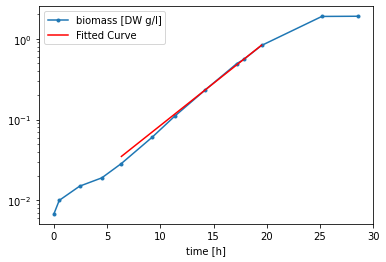

In [44]:
fig, ax = plt.subplots()
batch_data.plot(x='time [h]', y='biomass [DW g/l]', logy=True, ax=ax, style='.-');
ax.plot(exp_time_points, func(exp_time_points, *popt), 'r-', label="Fitted Curve")
ax.legend();

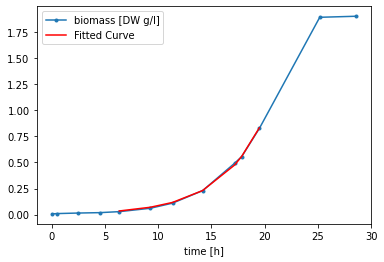

In [45]:
fig, ax = plt.subplots()
batch_data.plot(x='time [h]', y='biomass [DW g/l]', ax=ax, style='.-');
ax.plot(exp_time_points, func(exp_time_points, *popt), 'r-', label="Fitted Curve")
ax.legend();

### b) 

During exponential growth the yield coefficients should be constant. Prove it by plotting. Calculate the yield coefficients for biomass, ethanol and glycerol on glucose (Ysx, Yse, and Ysg) in g/g and in Cmol/Cmol.
Assume the generalized composition of the biomass: $CH_{1.8}O_{0.5}N_{0.2}$.

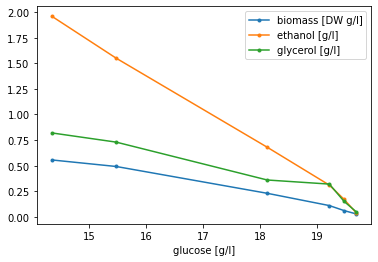

In [46]:
batch_data.iloc[4:10, 1:].plot(x='glucose [g/l]', style='.-');

The plots of concentrations of biomass, ethanol and glycerol against glucose are linear in the exponential growth phase, proving that the yield coefficients are constant.

Let's fit linear models to obtain the slopes/yield coefficients. This time we're going to use scikit-learn (which should come pre-installed with Anaconda) but .

In [47]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [48]:
df = batch_data[4:10] # again, let's use only the data points of the exponential growth phase

biomass [DW g/l] 2.0063513326697957 * y -0.09935749361199336; r2 = 0.9901882229397242; MSE = 0.0004201557854267896
ethanol [g/l] 6.957147291815009 * y -0.34841362076291327; r2 = 0.9976523894280985; MSE = 0.0012269199751399817
glycerol [g/l] 2.756361309924547 * y -0.13273278633500124; r2 = 0.9495606098019909; MSE = 0.0040195990705296815


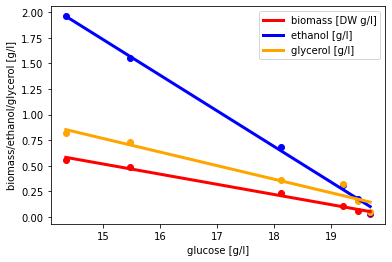

In [49]:
yields = dict() # store the fitted yield coefficients
colors = ('red', 'blue', 'orange') # colors for the plots
for i, var in enumerate(['biomass [DW g/l]', 'ethanol [g/l]', 'glycerol [g/l]']):
    reg = linear_model.LinearRegression()
    reg.fit(df[['glucose [g/l]']], df[var])
    predicted = reg.predict(df[['glucose [g/l]']])
    slope = reg.coef_[0]
    intercept = reg.intercept_
    yields[var.split(" ")[0]] = -1 * slope # store the result
    r2 = r2_score(df[var], predicted)
    mse = mean_squared_error(df[var], predicted)
    print(var, f'{intercept} * y {slope}; r2 = {r2}; MSE = {mse}')
    # plot the fitted lines
    plt.scatter(df[['glucose [g/l]']], df[var],  color=colors[i])
    plt.plot(df[['glucose [g/l]']], predicted, color=colors[i], linewidth=3, label=var)
    plt.legend()
    plt.xlabel('glucose [g/l]')
    plt.ylabel('biomass/ethanol/glycerol [g/l]')

In [50]:
yields

{'biomass': 0.09935749361199336,
 'ethanol': 0.34841362076291327,
 'glycerol': 0.13273278633500124}

$Y_{sx}$ = 0.098 g DW/g glucose, $Y_{se}$ = 0.347 g ethanol/g glucose, $Y_{sg}$ = 0.12 g glycerol/g glucose.

Converting into Cmol:

In [51]:
yields_cmol = dict()
yields_cmol['biomass'] = yields['biomass'] * (30/24.6) # (30 gGLC/CmolGLC) / (24.6 g gDW/CmolDW)
yields_cmol['ethanol'] = yields['ethanol'] * (30/23) # (30 gGLC/CmolGLC) / (23 gETH/CmolETH)
yields_cmol['glycerol'] = yields['glycerol'] * (30/30.67) # (30 gGLC/CmolGLC) / (30.67 gGLYC/CmolGLYC)

In [52]:
yields_cmol

{'biomass': 0.12116767513657727,
 'ethanol': 0.45445254882119124,
 'glycerol': 0.12983317867786232}

### c)

Make a C balance and calculate the yield of CO2 on glucose ($Y_{sc}$).

Since glucose is the only carbon source, all yields should add up to one ($Y_{sx} + Y_{se} + Y_{sg} + Y_{sc} = 1$).

In [53]:
co2_yield_cmol = 1 - yields_cmol['ethanol'] - yields_cmol['glycerol'] - yields_cmol['biomass']
co2_yield_cmol

0.29454659736436917

$Y_{sc} = 0.295$ (Cmol-CO2 / Cmol-GLC)

### d)

Using the calculated μmax and yield coefficients, calculate the specific consumption rate for glucose ($r_s$) and specific production rates for ethanol, glycerol and CO2 ($r_e$, $r_g$, and $r_c$). Use units of C-mmol/g DW·h.

* $r_s = Y_{xs} \mu_{max} = Y_{sx}^{-1} \mu_{max}$
* $r_e = Y_{se} r_s$
* $r_g = Y_{sg} r_s$
* $r_c = Y_{sc} r_s$

Glucose:

In [54]:
specific_rate_glc_mass = yields['biomass']**-1 * mu_max
specific_rate_glc_mass # g-glc gDW^-1 h^-1

2.423420566676058

In [55]:
specific_rate_glc_mmol = specific_rate_glc_mass * 1000/180 # 1000 mmol / 180 g-glc
specific_rate_glc_mmol # mmol gDW^-1 h^-1

13.463447592644767

In [56]:
specific_rate_glc_c_mmol = specific_rate_glc_mmol * 6 # glucose has 6 carbons
specific_rate_glc_c_mmol # c-mmol gDW^-1 h^-1

80.7806855558686

In [57]:
specific_rate_glc_c_mmol = specific_rate_glc_mass * (1000/30) # 1000 c-mmol / 30 g-glc
specific_rate_glc_c_mmol # c-mmol gDW^-1 h^-1

80.78068555586862

Ethanol:

In [58]:
specific_rate_eth_mass = yields['ethanol'] * specific_rate_glc_mass
specific_rate_eth_mass # g-eth gDW^-1 h^-1

0.8443527342669165

In [59]:
specific_rate_eth_mmol = specific_rate_eth_mass * 1000/46.07 # 1000 mmol / 46.07 g-eth
specific_rate_eth_mmol # mmol gDW^-1 h^-1

18.327604390425797

Glycerol:

In [60]:
specific_rate_glyc_mass = yields['glycerol'] * specific_rate_glc_mass
specific_rate_glyc_mass # g-eth gDW^-1 h^-1

0.32166736427646087

In [61]:
specific_rate_eth_mmol = specific_rate_glyc_mass * 1000/92.1 # 1000 mmol / 92.1 g-glyc
specific_rate_eth_mmol # mmol gDW^-1 h^-1

3.4925881028931696

CO2:

In [62]:
specific_rate_co2_mmol = co2_yield_cmol * specific_rate_glc_mass * 30 # g-glc/ cmol-glc
specific_rate_co2_mmol # mmol-co2 gDW^-1 h^-1

21.41430845691793